In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from IPython.display import Image, display
tf.compat.v1.enable_eager_execution()

# Initialization ---------------------------------------------------------

#Input Image Dimensions
img_width = 200
img_height = 200

#Loading Model
model_name = 'res_cnn_03_11_18_54'
model = tf.keras.models.load_model("./data/models/"+model_name)

# Defining Functions --------------------------------------------------------------------

#Setting up Gradient Ascent
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    
    #Disclude border pixels to remove artifacts
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
        
    #Compute gradients and normalize them
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

#Setting up filter visualization loop
def initialize_image():
    
    #Starting from a gray image with random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    return (img - 0.5) * 0.25

def deprocess_image(img):
    
    #Normalize array with mean 0, varience 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15
    img += 0.5
    img = np.clip(img, 0, 1)
    
    #Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img
    
def visualize_filter(filter_index):
    
    #Run gradient ascent for 30 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)
    img = deprocess_image(img[0].numpy())    
    return loss, img

C:\Users\illew\anaconda3\envs\tf-gpu-hardness\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31


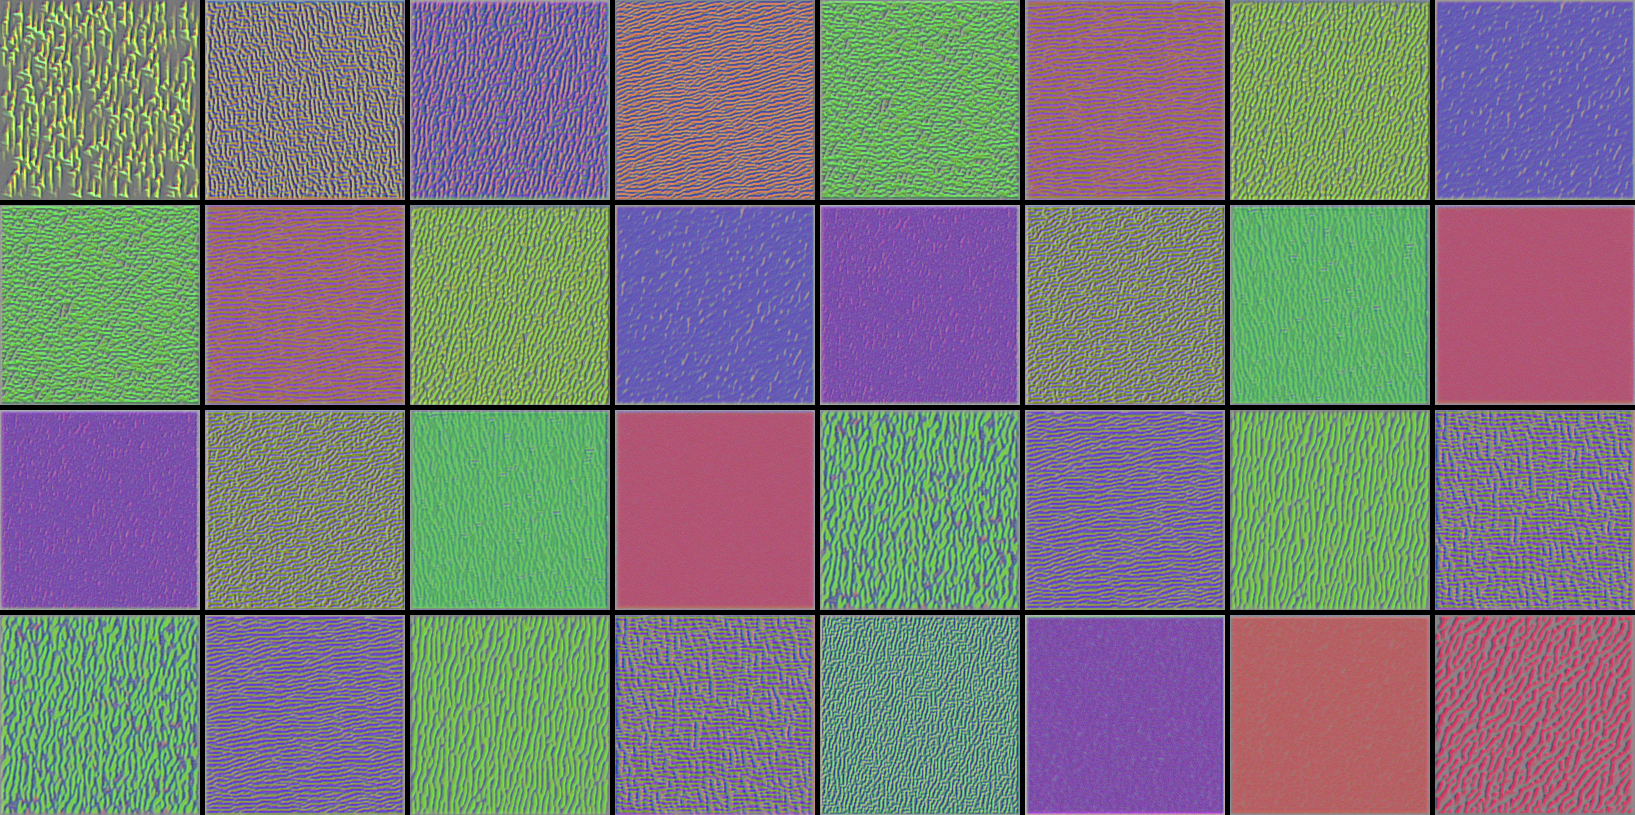

In [2]:
#Loading Specific Layer
layer_name = "batch_normalization_5"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

# Running The Process -----------------------------------------------------------------

#Compute image imputs to maximize per-filter activations for all 32 filters of each layer
all_imgs = []
for filter_index in range(32):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)
    
#Building picture frame for tiling filter visualizations
margin = 5
m = 4
n = 8
cropped_width = img_width
cropped_height = img_height
width = m*cropped_width+(m-1)*margin
height = n*cropped_height+(n-1)*margin
stitched_filters = np.zeros((width, height, 3))

#Fill frame with filter images
for i in range(m):
    for j in range(n):
        img = all_imgs[i*m+j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img(str(layer_name)+".png", stitched_filters)
display(Image(str(layer_name)+".png"))